# GeekBrains Real Estate Price Prediction Competition @ Kaggle

# Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

# 1. Разделение датасета и поиск гиперпараметров
from sklearn.model_selection import train_test_split, cross_val_score, KFold
# 2. Трансформация данных
from sklearn.preprocessing import StandardScaler
# 3. Модели
from sklearn.ensemble import GradientBoostingRegressor
# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Скрипт для уменьшения занимаемой памяти DataFrame**

Проблема - df.mean() возвращает inf для типов float16.\
Поэтому делаем так, что функция не будет переводить в float16.\
Подробности в Pandas GitHub Issue: https://github.com/pandas-dev/pandas/issues/22841

In [3]:
def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
        From Kaggle Notebook:
        https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                # Breaks statistics because of the Pandas issue
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    mem_decrease_percent = 100 * (start_mem - end_mem) / start_mem
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    print(f"Decreased by {mem_decrease_percent:.1f}%")
    
    return df

**Скрипт визуализации диаграммы распределения вероятности**

In [4]:
def plot_dist_with_stats(series: pd.Series, *, var_name: str='Variable', bins: int=30, log=False):
    plt.figure(figsize=(12, 6))
    
    distplot = sns.distplot(series, bins=bins, fit=norm,
                            hist_kws={'ec': 'white', 'log': log}, 
                            fit_kws={'label': 'Normal Distribution'})
    
    # Plotting the 3 averages
    tallest_bin_height = max([b.get_height() for b in distplot.patches])
    y = [0, tallest_bin_height]
    # Mean
    plt.plot([series.mean()] * len(y), y, color='green', linestyle='dashed', label='mean')
    # Median
    plt.plot([series.median()] * len(y), y, color='blue', linestyle='dashed', label='median')
    # Mode (adjusted)
    var_bin_count = len(series) // 100
    var_bin_range = (series.max() - series.min()) / var_bin_count
    var_bins = series // var_bin_range * var_bin_range
    adjusted_mode = var_bins.mode()[0]
    plt.plot([adjusted_mode] * len(y), y, color='red', linestyle='dashed', label='adjusted mode')

    plt.legend(loc='upper right')
    plt.title(f"Distribution of {var_name}")
    
    plt.show()

**Скрипт визуализации частоты значений переменной**

In [5]:
def plot_bar_frequency(series: pd.Series, *, show_labels=False, log=False):
    freq = series.value_counts()
    
    fig, ax = plt.subplots()
    ax.bar(freq.index, freq, log=log)
    
    ax.set_title(f"{'Log ' if log else ''}{series.name}")
    ax.set_ylabel('Frequency')
    
    if show_labels:
        for i, patch in enumerate(ax.patches):
            width = patch.get_x() + patch.get_width() / 2
            height = patch.get_height() + 5
            ax.annotate(freq[i],
                        (width, height),
                        ha='center',
                        va='bottom')
        
    return ax

**Скрипт визуализации предсказаний модели**

In [6]:
def eval_predictions(train_true: pd.Series, train_pred: pd.Series, test_true: pd.Series, test_pred: pd.Series) -> None:
    """ Evaluate model predictions with MSE, RMSE and R2 score.
        Function from the GeekBrains tutorial notebook.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,10))
    ax = ax.flatten()
    
    print(f"Train R2:\t{round(r2(train_true, train_pred), 3)}", 
          f"Train RMSE:\t{round(np.sqrt(mse(train_true, train_pred)), 3)}", 
          f"Train MSE:\t{round(mse(train_true, train_pred), 3)}", 
          sep='\n')
    print()
    print(f"Test R2:\t{round(r2(test_true, test_pred), 3)}", 
          f"Test RMSE:\t{round(np.sqrt(mse(test_true, test_pred)), 3)}", 
          f"Test MSE:\t{round(mse(test_true, test_pred), 3)}", 
          sep='\n')
    
    min_coord = min(train_true.min(), train_pred.min(), test_true.min(), test_pred.min())
    max_coord = max(train_true.max(), train_pred.max(), test_true.max(), test_pred.max())
    
    sns.scatterplot(x=train_pred, y=train_true, ax=ax[0])
    ax[0].plot([min_coord, max_coord], [min_coord, max_coord], linestyle='--', color='black')
    ax[0].set_title("Train dataset Prediction")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("True")
    
    sns.scatterplot(x=test_pred, y=test_true, ax=ax[1])
    ax[1].plot([min_coord, max_coord], [min_coord, max_coord], linestyle='--', color='black')
    ax[1].set_title("Test dataset Prediction")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("True")
    
    plt.show()

**Пути к файлам**

train.csv - тренировочный датасет,\
test.csv - тестовый датасет для предсказаний

In [7]:
TRAIN_FILEPATH = './dataset/train.csv'
PREPARED_TRAIN_FILEPATH = './dataset/train_prepared.csv'
TEST_FILEPATH = './dataset/test.csv'
SCALER_FILEPATH = './scaler.pkl'
MODEL_FILEPATH = './model.pkl'

# Загрузка данных из файла в DataFrame

**Описание задачи**

Цель - предсказать стоимость квартиры в датасете test.csv на основании имеющихся признаков.\
Тренировка модели машинного обучения будет проходить на датасете train.csv с имеющимися целевыми значениями.

Эта цель может быть полезна для:
* банков - для принятия решений о выдаче кредита
* продавцов квартир, агентств недвижимости, площадок объявлений - для понимания, какую выручку можно получить от продажи
* инвесторов - для поиска недооцененных активов и оценки прибыльности инвестиции

**Описание датасета**

В датасете описаны квартиры в Москве и Московской области с их различными признаками и целевой переменной - ценой квартиры Price.\
Датасет является табличными, структурированными данными.

Признаки датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры, **целевая переменная**

In [8]:
train_df = pd.read_csv(TRAIN_FILEPATH, sep=',')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [9]:
test_df = pd.read_csv(TEST_FILEPATH, sep=',')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


Количество наблюдений в датасете.

In [10]:
print(f"Train samples: {train_df.shape[0]}")
print(f"Test samples: {test_df.shape[0]}")

Train samples: 10000
Test samples: 5000


Количество признаков в датасете (вместе с целевой переменной Price).

In [11]:
train_df.shape[1]

20

Проверяем, что в train и test одинаковое количество признаков.

In [12]:
train_df.shape[1] - 1 == test_df.shape[1]

True

**Уменьшаем занимаемую память DataFrame**

In [13]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


**Типы данных переменных**

Признак Id нам не нужен, так как он не несет никакой информации.

In [14]:
train_df = train_df.drop(columns=['Id'])

In [15]:
train_df.dtypes

DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

# 1. EDA и Preprocessing

## 1.1. Анализ целевой переменной Price

**Пропущенные значения**

In [16]:
train_df['Price'].isna().sum()

0

Пропущенных значений для целевой переменной нет.

**Основная описательная статистика**

In [17]:
train_df['Price'].describe()

count     10000.000000
mean     214138.859375
std       92872.289062
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

In [18]:
train_df['Price'].mode()

0    182938.078125
1    204576.421875
2    238608.656250
3    298194.500000
dtype: float32

Можем заметить, что медиана < среднего арифметического, что говорит о положительной ассиметрии.\
Значение max намного превышает значение 3 квартиля, что говорит о положительном коэффициенте эксцесса.\
Проверим это.

**Гистограмма плотности распределения целевой переменной Price**

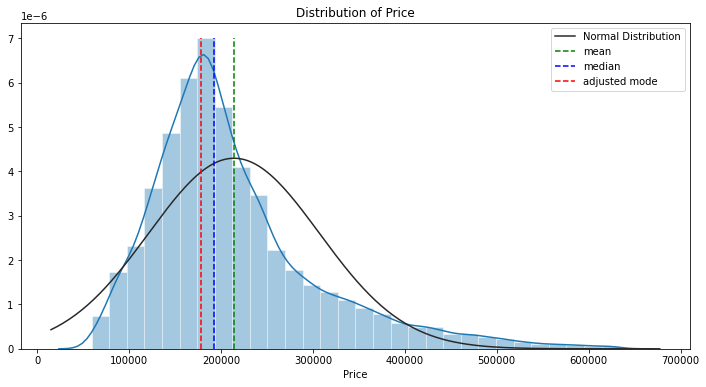

In [19]:
plot_dist_with_stats(train_df['Price'], var_name='Price')

Распределение отличается от нормального.

**Ассиметрия и эксцесс:**

In [20]:
print(f"Skewness: {train_df['Price'].skew():.3f}")
print(f"Kurtosis: {train_df['Price'].kurt():.3f}")

Skewness: 1.367
Kurtosis: 2.249


Коэф. ассиметрии и эксцесса положительны, поэтому стоит ожидать немало выбросов в правом хвосте Price.

**Box plot для проверки**

(0.0, 700000.0)

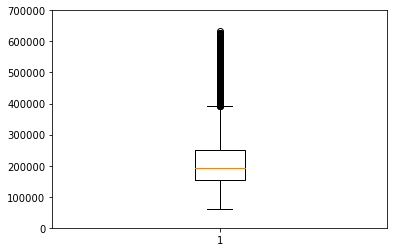

In [21]:
plt.boxplot(train_df['Price'])
plt.ylim([0, 700000])

Box plot подтверждает гипотезу о большом количестве выбросов в правом хвосте Price.

## 1.2. Анализ признаков датасета

### 1.2.1. Количественные признаки

Посмотрим основную описательную статистику датасета.

In [22]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Мода количественных признаков.

In [23]:
train_df.mode(axis=0).loc[0, :]

DistrictId               27
Rooms                     2
Square              37.4982
LifeSquare          33.8597
KitchenSquare             1
Floor                     4
HouseFloor               17
HouseYear              1977
Ecology_1        0.00712232
Ecology_2                 B
Ecology_3                 B
Social_1                  2
Social_2                264
Social_3                  0
Healthcare_1            540
Helthcare_2               0
Shops_1                   0
Shops_2                   B
Price                182938
Name: 0, dtype: object

Пропущенные значения:
* LifeSquare - 2113 наблюдений из 10000.
* Healthcare_1 - 4798 наблюдений из 10000.

Также можно сразу заметить некоторые выбросы в данных:
* LifeSquare max = 7480.59 - похоже на ошибку при заполнении,
* KitchenSquare max = 2014 и std = 28.56 при 75% квартиле = 9 - явная ошибка,
* HouseYear max = 2.0e+07 и mean = 3.99e+03, std = 2.0e+05 - явно ошибка в данных, таких годов строительства нет,
* Square min = 1.13 и LifeSquare min = 0.37 - очень странно, что такая маленькая площадь у квартир, похоже на ошибки,
* HouseFloor max = 117 при 75% квартиле = 12 - выброс,
* Social_3 max = 141 и std = 23.83 при 75% квартиле = 5 - выброс,
* Для Rooms, KitchenSquare, HouseFloor min = 0 - похоже на пропущенные значения или ошибки в данных,
* Для Id, DistrictId min = 0 также может быть пропущенными значениями или ошибками, но не обязательно.

### 1.2.2. Категориальные признаки

<AxesSubplot:title={'center':'Log Ecology_2'}, ylabel='Frequency'>

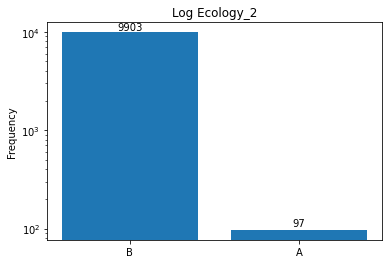

In [24]:
plot_bar_frequency(train_df['Ecology_2'], show_labels=True, log=True)

<AxesSubplot:title={'center':'Log Ecology_3'}, ylabel='Frequency'>

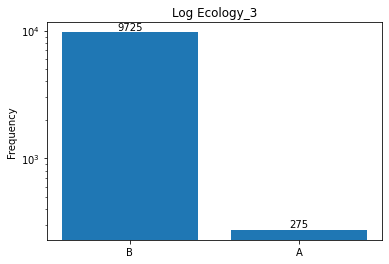

In [25]:
plot_bar_frequency(train_df['Ecology_3'], show_labels=True, log=True)

<AxesSubplot:title={'center':'Log Shops_2'}, ylabel='Frequency'>

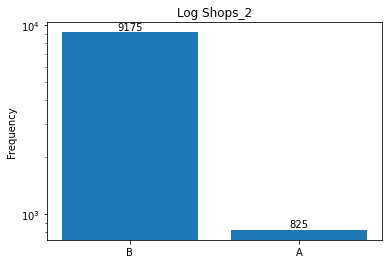

In [26]:
plot_bar_frequency(train_df['Shops_2'], show_labels=True, log=True)

Категории A и B в категориальных признаках Ecology_2, Ecology_3, Shops_2 заметно несбалансированны.

## 1.3. Обработка выбросов

Поочередно посмотрим все признаки датасета.

In [27]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

#### DistrictId

Посмотрим распределение DistrictId более наглядно.

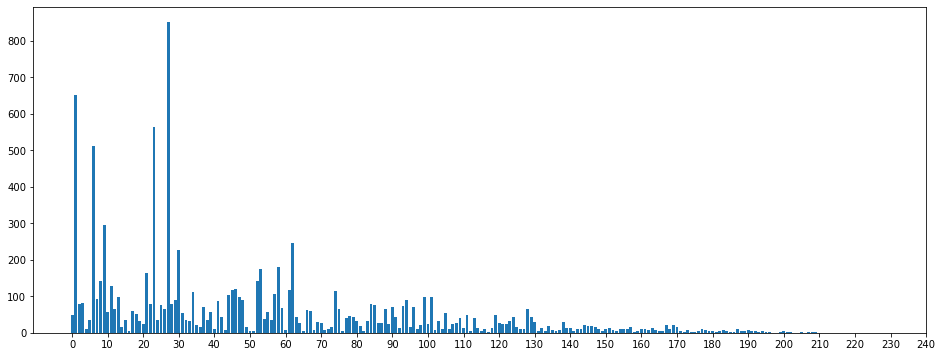

In [28]:
plt.figure(figsize=(16,6))

district_counts = train_df['DistrictId'].value_counts()
plt.bar(district_counts.index, district_counts)
plt.xticks(np.arange(0, 250, 10))
plt.show()

Проверим, является ли ошибкой DistrictId, равные 0.

In [29]:
train_df[train_df['DistrictId'] == 0].sample(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
20,0,3.0,103.605293,47.799427,10.0,12,17.0,2002,0.319809,B,B,25,4756,16,2857.0,5,8,B,521919.062500
9400,0,1.0,32.967873,20.883841,5.0,5,5.0,1961,0.319809,B,B,25,4756,16,2857.0,5,8,B,142799.437500
4491,0,3.0,81.496979,45.754761,10.0,19,22.0,2008,0.319809,B,B,25,4756,16,2857.0,5,8,B,427613.406250
9701,0,2.0,60.789974,NaN,1.0,4,17.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,162985.109375
4059,0,3.0,92.298721,51.617939,13.0,5,19.0,2012,0.006076,B,B,30,5285,0,645.0,6,6,B,285934.187500


In [30]:
train_df[train_df['DistrictId'] == 0].shape

(48, 19)

Есть только 48 квартир с DistrictId == 0.\
По данным это значение не похоже на ошибочное, это просто id района.

#### Rooms

In [31]:
train_df['Rooms'].value_counts().sort_values(ascending=False)

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Наиболее часто встречаются квартиры с 1, 2 и 3 комнатами, а медиана Rooms - 2.

Есть 8 квартир с 0 комнат.\
В квартире не может не быть комнат, поэтому эти значения можно считать ошибкой.\
Заменим эти значения на 1.

In [32]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

Также есть всего 3 квартиры с количеством комнат > 6 (10 и 19).\
Их можно считать выбросами, так как такое количество комнат бывает крайне редко, если бывает вообще.\
Заменим эти значения медианой.

In [33]:
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()

In [34]:
train_df['Rooms'].value_counts().sort_values(ascending=False)

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

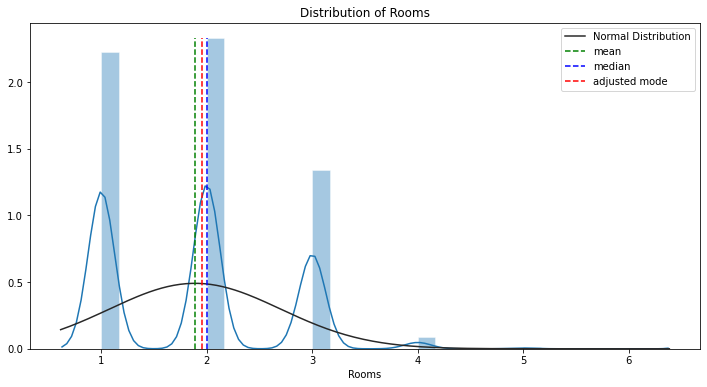

In [35]:
plot_dist_with_stats(train_df['Rooms'], var_name='Rooms')

#### Square

In [36]:
train_df['Square'].value_counts().sort_values(ascending=False)

65.285133    2
44.482914    2
37.498161    2
81.867165    2
80.794792    2
            ..
62.999760    1
34.998058    1
63.997875    1
80.876266    1
38.704697    1
Name: Square, Length: 9995, dtype: int64

Нет часто повторяющихся значений.\
Чтобы лучше понять диапазон признака, посмотрим его распределение.

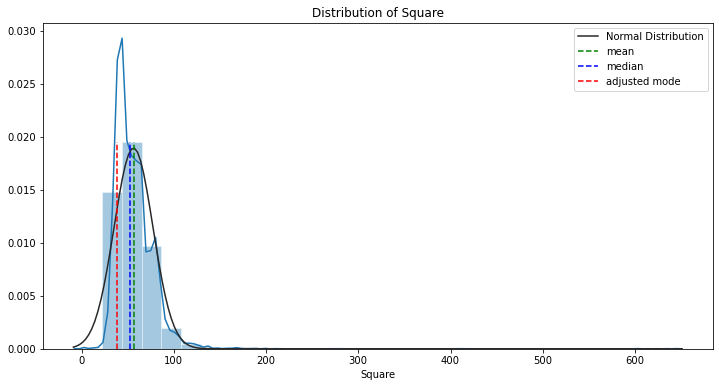

In [37]:
plot_dist_with_stats(train_df['Square'], var_name='Square')

Есть слишком маленькие по площади квартиры - Square < 10.\
Таких квартир даже нет в продаже, так что это ошибочные данные.

In [38]:
train_df[train_df['Square'] < 10].shape

(12, 19)

Таких квартир всего 12.\
В таком случае можно просто установить значение Square = 10 для таких квартир.

In [39]:
train_df.loc[train_df['Square'] < 10, 'Square'] = 10

Посмотрим квартиры в правом длинном хвосте, правые 0.5%.

In [40]:
square_quantile = train_df['Square'].quantile(q=0.995)
square_quantile

132.82090370178219

In [41]:
train_df[train_df['Square'] > square_quantile].shape

(50, 19)

Квартир с общей площадью > квантиля 99.5% всего 50.\
Посмотрим на соответствующую стоимость этих квартир.

In [42]:
train_df.loc[train_df['Square'] > square_quantile, 'Price'].mean(), \
train_df.loc[train_df['Square'] > square_quantile, 'Price'].median()

(279285.2, 211253.19)

In [43]:
train_df.loc[~(train_df['Square'] > square_quantile), 'Price'].mean(), \
train_df.loc[~(train_df['Square'] > square_quantile), 'Price'].median()

(213811.48, 192072.98)

In [44]:
train_df['Price'].mean(), train_df['Price'].median()

(214138.86, 192269.66)

Можно заметить что квартиры с выскоим Square стоят заметно дороже, у них выше Price.\
Заменим эти значения Square на значение квантиля 99.5%, чтобы отразить это влияние.

In [45]:
train_df.loc[train_df['Square'] > square_quantile, 'Square'] = square_quantile

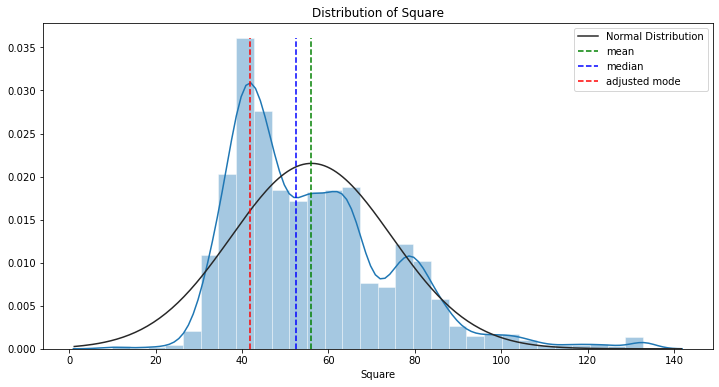

In [46]:
plot_dist_with_stats(train_df['Square'], var_name='Square')

#### LifeSquare

In [47]:
train_df['LifeSquare'].value_counts(dropna=False).sort_values(ascending=False)

NaN          2113
33.859653       2
47.001354       1
34.003960       1
47.015720       1
             ... 
32.999142       1
26.499628       1
24.499641       1
45.999352       1
19.250271       1
Name: LifeSquare, Length: 7887, dtype: int64

Нет часто повторяющихся значений.\
Посмотрим его распределение.

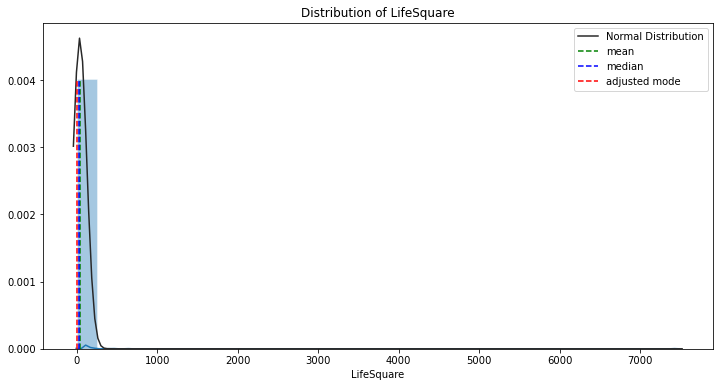

In [48]:
plot_dist_with_stats(train_df['LifeSquare'], var_name='LifeSquare')

Можно заметить, что есть выброс с довольно большим значением.\
Посмотрим все квартиры с жилой площадью более 99.5% квантиля.

In [49]:
lifesquare_quantile = train_df['LifeSquare'].quantile(q=0.995)
lifesquare_quantile

107.69063

In [50]:
train_df[train_df['LifeSquare'] > lifesquare_quantile].shape

(40, 19)

Таких квартир 40.\
Есть 1 квартира с жилой площадью 7480.59 и общей площадью 81.69 - явная ошибка заполнения.\
Вполне вероятно, что при заполнении человек ошибся на несколько разрядов.\
Обработаем эти значения - заполним их медианой.

In [51]:
train_df.loc[train_df['LifeSquare'] > lifesquare_quantile, 'LifeSquare'] = train_df['LifeSquare'].median()

Теперь посмотрим квартиры с слишком маленькой жилой площадью, LifeSquare < 10.

In [52]:
train_df[train_df['LifeSquare'] < 10].shape

(205, 19)

Таких квартир 205, что относительно значимо.\
Заменим на логичное минимальное значение для жилой площади - 10 кв.м.

In [53]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

Cнова посмотрим распределение значений LifeSquare.

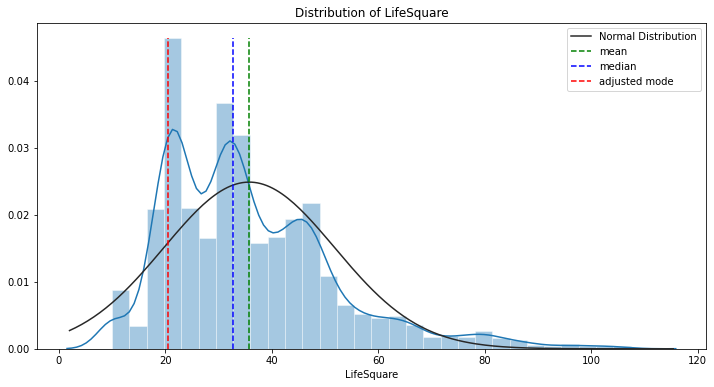

In [54]:
plot_dist_with_stats(train_df['LifeSquare'], var_name='LifeSquare')

Теперь данные признака LifeSquare более нормальные и стало легче увидеть в них закономерности.

#### KitchenSquare

In [55]:
train_df['KitchenSquare'].value_counts().sort_values(ascending=False)

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
37.0         2
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
32.0         2
58.0         2
30.0         2
53.0         1
63.0         1
31.0         1
123.0        1
73.0         1
23.0         1
29.0         1
21.0         1
26.0         1
75.0         1
36.0         1
1970.0       1
39.0         1
62.0         1
42.0         1
84.0         1
27.0         1
78.0         1
60.0         1
35.0         1
2014.0       1
40.0         1
48.0         1
66.0         1
96.0         1
72.0         1
54.0         1
Name: KitchenSquare, dtype: int64

Нет часто повторяющихся значений.\
Посмотрим его распределение.

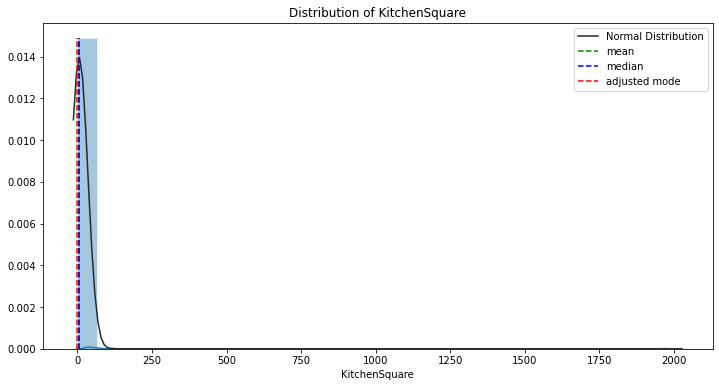

In [56]:
plot_dist_with_stats(train_df['KitchenSquare'], var_name='KitchenSquare')

In [57]:
kitchsquare_quantile = train_df['KitchenSquare'].quantile(q=0.995)
kitchsquare_quantile

20.0

In [58]:
train_df[train_df['KitchenSquare'] > kitchsquare_quantile].shape

(48, 19)

Таких квартир 48.\
Заменим значения признака медианой.

In [59]:
train_df.loc[train_df['KitchenSquare'] > kitchsquare_quantile, 'KitchenSquare'] = train_df['KitchenSquare'].median()

Посмотрим квартиры со значением KitchenSquare < 3.

In [60]:
train_df[train_df['KitchenSquare'] < 3].shape

(3161, 19)

Таких квартир 3161, это довольно много.\
Квартиры с кухней менее 3 кв.м. на рынке Москвы и МО очень мало судя по краткому поиску по площадкам продажи жилья.\
Заменим имеющиеся значения значениями от 3 кв.м. до значения 75% квартиля.

In [61]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = np.random.randint(3, train_df['KitchenSquare'].quantile(q=0.75))

Посмотрим распределение значений KitchenSquare.

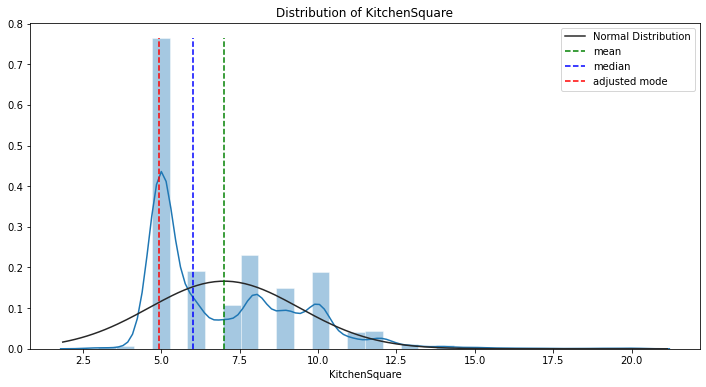

In [62]:
plot_dist_with_stats(train_df['KitchenSquare'], var_name='KitchenSquare')

Теперь, когда сильные выбросы и ошибки обработаны, можно увидеть, что распределение KitchenSquare очень близко к нормальному.

#### Square < LifeSquare + KitchenSquare

Как можно увидеть в просмотренных про площади данных, есть квартиры, где общая площадь меньше суммы жилой и кухонной площадей, а то и меньше одной из них.\
В реальности так быть не может, поэтому удостоверимся, что это будет исправлено.

Посмотрим проблемные квартиры.

In [63]:
outlier_square_df = train_df[train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']]
outlier_square_df.shape

(1158, 19)

Есть 1158 квартир, где общая площадь меньше суммы жилой площади и площади кухни.

Заменим значения кухонь таких квартир на медиану,
Поправим Square так, чтобы она была = (LifeSquare + KitchenSquare + 6).\
6 кв.м. - это примерная мера средней нежилой площади в квартире, за исключением кухни.

In [64]:
additional_nonlife_square = 6
train_df.loc[train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'], 
               'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'], 
               'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare'] + additional_nonlife_square

In [65]:
outlier_square_df = train_df[train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']]
outlier_square_df.shape

(0, 19)

#### HouseYear

In [66]:
train_df['HouseYear'].value_counts().sort_values(ascending=False)

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1916           1
1928           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

У некоторых квартир год постройки дома 4968 или 20052011.\
Это явная ошибка при заполнении.\
Посмотрим все квартиры со значением HouseYear > 2020 (текущий год).

In [67]:
train_df[train_df['HouseYear'] > 2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250
4189,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375


Таких выброса всего 2.\
Исправим их.

In [68]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].median()

Посмотрим распределение значений HouseYear.

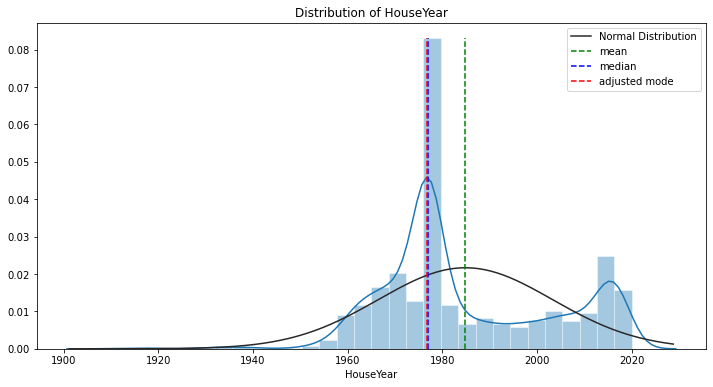

In [69]:
plot_dist_with_stats(train_df['HouseYear'], var_name='HouseYear')

Можно заметить большое количество квартир, для которых дом построен в 1977 году.\
Узнаем подробнее.

In [70]:
train_df['HouseYear'].value_counts().head(10)

1977.0    2654
2017.0     308
2016.0     305
2015.0     299
2014.0     210
1970.0     194
1969.0     190
1972.0     178
1971.0     177
2018.0     175
Name: HouseYear, dtype: int64

26.54% всех квартир датасета в домах, построенных в 1977 году.

#### HouseFloor

In [71]:
train_df['HouseFloor'].value_counts().sort_values(ascending=False)

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
99.0        2
39.0        2
48.0        2
38.0        1
26.0        1
36.0        1
44.0        1
45.0        1
31.0        1
29.0        1
117.0       1
47.0        1
Name: HouseFloor, dtype: int64

Есть значения HouseFloor == 99, 117.\
В Европе нет зданий с такой этажностью, поэтому это точно ошибка.

Посмотрим на эти квартиры.

In [72]:
train_df[train_df['HouseFloor'] > 95]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6131,5,1.0,60.709602,48.709602,6.0,6,99.0,1977.0,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.12500
8599,74,2.0,86.579811,74.579811,6.0,5,99.0,1977.0,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.90625
8854,30,2.0,78.811790,66.811790,6.0,8,117.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.37500


Скорее всего эти значения - ошибка ввода, должно было быть 9 и 17 этажей соответственно, так как признак Floor этих квартир не превышает 8.\
Также здания в 9 и 17 этажей - самые популярные в датасете.

Заменим значения HouseFloor > 95 выбросов на медиану.

In [73]:
train_df.loc[train_df['HouseFloor'] > 95, 'HouseFloor'] = train_df['HouseFloor'].median()

Также в частоте значений можно заметить, что есть 269 квартир в домах с 0 этажами.

Посмотрим на эти квартиры.

In [74]:
train_df[train_df['HouseFloor'] == 0].sample(5)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1493,27,3.0,46.923653,NaN,5.0,24,0.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A,149404.828125
5753,62,3.0,127.417557,NaN,5.0,9,0.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A,282877.343750
5348,27,2.0,60.685738,NaN,5.0,13,0.0,1977.0,0.211401,B,B,9,1892,0,NaN,0,1,B,127644.093750
700,27,2.0,41.610104,NaN,5.0,7,0.0,1977.0,0.072158,B,B,2,629,1,NaN,0,0,A,120724.054688
556,35,1.0,47.410774,NaN,5.0,4,0.0,1977.0,0.089040,B,B,33,7976,5,NaN,0,11,B,218138.093750


In [75]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseYear'].value_counts().sort_values(ascending=False)

1977.0    253
2016.0      6
2018.0      4
2015.0      4
2017.0      1
2014.0      1
Name: HouseYear, dtype: int64

Можно заметить, что большинство квартир с признаком HouseFloor == 0 находится в домах 1977 года постройки.\
Проверим, насколько этажность дома HouseFloor связана с годом постройки HouseYear.

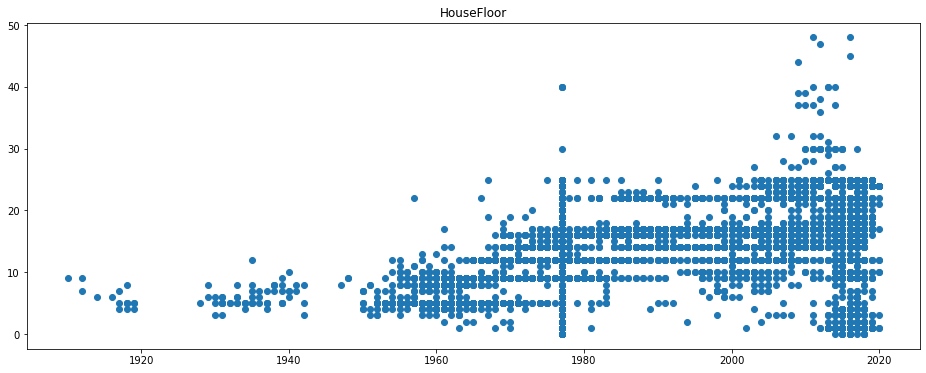

In [76]:
plt.figure(figsize=(16,6))

plt.scatter(train_df['HouseYear'], train_df['HouseFloor'])

plt.title("HouseFloor")

plt.show()

Заменим наблюдения с нулевыми значениями HouseFloor на медианное значение HouseFloor для домов 1977 года постройки, так как этажность дома понемногу увеличивается с увеличением года постройки.

In [77]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df.loc[train_df['HouseYear'] == 1977, 'HouseFloor'].median()

Посмотрим распределение HouseFloor.

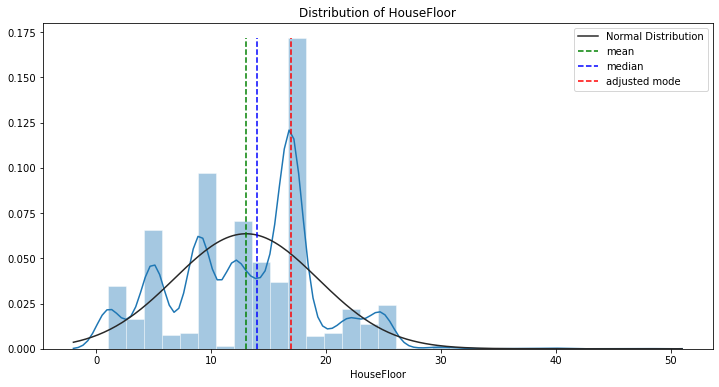

In [78]:
plot_dist_with_stats(train_df['HouseFloor'], var_name='HouseFloor')

#### Floor

In [79]:
train_df['Floor'].value_counts().sort_values(ascending=False)

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
37      1
42      1
33      1
31      1
Name: Floor, dtype: int64

Сильных выбросов особо не видно.\
При обработке выбросов признака HouseFloor были замечены квартиры, где номер их этажа был больше, чем этажность дома.\
Посмотрим такие квартиры.

In [80]:
train_df[train_df['Floor'] > train_df['HouseFloor']].shape

(1578, 19)

Таких квартир 1578 штук, довольно немало.\
Зададим этим квартирам случайный этаж из диапазона от 1 до максимального этажа здания этой квартиры.

In [81]:
floor_index = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_index, 'Floor'] = train_df.loc[floor_index, 'HouseFloor'].map(lambda x: np.random.randint(1, x + 1))

Посмотрим распределение Floor.

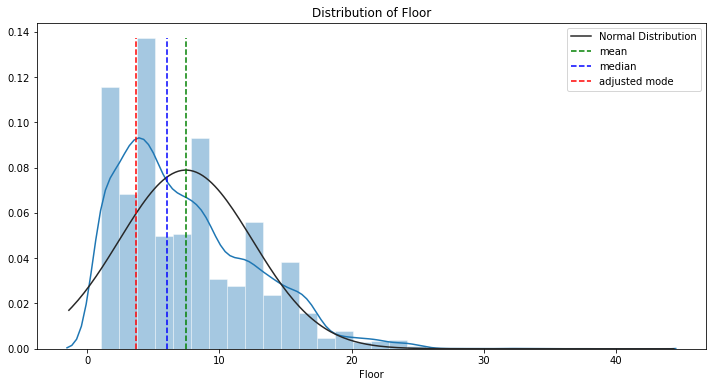

In [82]:
plot_dist_with_stats(train_df['Floor'], var_name='Floor')

#### Social_3

In [83]:
train_df['Social_3'].value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

У признака Social_3 не особо большое количество различных значений.\
Можно заметить, что большинство значений лежат в диапазоне [0, 16].\
Посмотрим количество квартир со значением Social_3 > 50.

In [84]:
cutoff_social_3 = 20
train_df[train_df['Social_3'] > cutoff_social_3].shape

(623, 19)

Таких квартир 623.\
Посмотрим на эти квартиры более подробно.

In [85]:
train_df[train_df['Social_3'] > cutoff_social_3].sample(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9146,135,2.0,52.366535,31.201674,8.0,4,12.0,1981.0,0.007659,B,B,35,7077,56,2301.0,3,19,B,294877.031250
716,163,3.0,64.948563,40.724483,8.0,2,12.0,1981.0,0.007659,B,B,35,7077,56,2301.0,3,19,B,141934.843750
6005,30,1.0,42.461319,NaN,5.0,10,17.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,120802.203125
7703,30,2.0,55.383579,NaN,5.0,12,17.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,203826.500000
9276,30,3.0,85.947060,NaN,5.0,16,22.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,222992.578125
9252,14,2.0,42.722393,24.359615,7.0,3,12.0,1977.0,0.042032,B,B,37,6856,84,1940.0,2,5,B,66421.734375
5016,182,2.0,77.200027,65.200027,6.0,7,8.0,1918.0,0.015017,B,B,17,3079,59,2890.0,0,8,B,443270.812500
547,30,3.0,83.596367,NaN,5.0,3,16.0,1977.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,198393.453125
4537,103,1.0,36.184925,19.883247,5.0,1,5.0,1969.0,0.000699,B,B,14,3369,24,4129.0,0,3,B,145385.187500
6977,30,2.0,132.820908,32.781261,10.0,1,19.0,2019.0,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500


По данным можно заметить, что DistrictId и социальные, медицинские, магазинные показатели коррелируют - в одном районе одни и те же показатели.\
Проверим эту гипотезу - посмотрим на стандартное отклонение этих признаков внутри районов.

In [86]:
high_social_3 = train_df[train_df['Social_3'] > cutoff_social_3]
groupby = high_social_3.iloc[:, np.r_[0, 8:18]].groupby('DistrictId')
groupby.std().dropna()

,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
DistrictId,,,,,,,
4,0.158262,11.200649,2304.754611,48.011362,570.562784,0.809040,8.914748
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43,0.007732,2.587746,1717.745694,42.439032,954.360669,1.552648,7.763238
50,0.016505,9.110434,1650.469706,17.597348,821.109158,0.816497,6.946222
51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
53,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60,0.182618,4.381780,773.931974,4.381780,0.547723,0.000000,4.381780
73,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Можно увидеть, что в большинстве районов значения социальных, медицинских и магазинных показателей на самом деле одни и те же для всех квартир.\
Только в районах с DistrictId == 4, 43, 50, 159, 175 есть какая-то вариация в этих признаках.

Чтобы понять, насколько важна зависимость между высоким Social_3 и стоимостью квартиры, посмотрим на средние значения для групп квартир с Social_3 больше и меньше 20, а также на общее показатели для датасета.

In [87]:
high_social_3['Price'].mean(), high_social_3['Price'].median()

(253920.11, 217398.25)

In [88]:
low_social_3 = train_df[train_df['Social_3'] <= cutoff_social_3]

low_social_3['Price'].mean(), low_social_3['Price'].median()

(211495.81, 190906.83)

In [89]:
train_df['Price'].mean(), train_df['Price'].median()

(214138.86, 192269.66)

Судя по данным, высокий показатель Social_3 на самом деле заметно повышает среднюю стоимость квартиры.\
На основании этого, заменим имеющиеся выбросы (Social_3 > 20) на случайные значения в промежутке [15, 20], чтобы сохранить алияние этого признака на стоимость квартиры.\
Лучше распределить все эти значения выбросов по промежутку, чем заменить их все на 1 значение 20 - чтобы искусственно не создавать большое количество одинаковых значений.

In [90]:
train_df.loc[train_df['Social_3'] > cutoff_social_3, 
             'Social_3'] = np.random.randint(cutoff_social_3 - 5, 
                                             cutoff_social_3 + 1, 
                                             train_df.loc[train_df['Social_3'] > cutoff_social_3].shape[0])

Посмотрим на распределение признака.

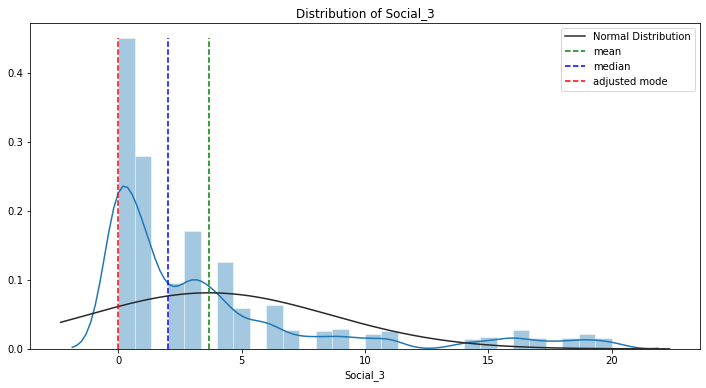

In [91]:
plot_dist_with_stats(train_df['Social_3'], var_name='Social_3')

#### Healthcare_1

В описательной статистике можно увидеть, что у признака Healthcare_1 4798 пропущенных значений - почти половина.

In [92]:
train_df['Healthcare_1'].value_counts(dropna=False)

NaN       4798
540.0      511
30.0       348
1046.0     245
750.0      163
          ... 
370.0       14
32.0        12
1815.0      10
35.0         2
0.0          1
Name: Healthcare_1, Length: 80, dtype: int64

В связи с этим, в секции "Заполнение пропущенных значений" разберемся с этим признаком отдельно.

#### Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Helthcare_2, Shops_1, Shops_2

In [93]:
train_df['Ecology_1'].value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.014334      1
0.012522      1
Name: Ecology_1, Length: 129, dtype: int64

In [94]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [95]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [96]:
train_df['Social_1'].value_counts()

2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
37    205
24    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

In [97]:
train_df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
568       3
1423      3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

In [98]:
train_df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

In [99]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

In [100]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

Сильных выбросов в этих признаках нет.\
Возможно получилось бы идентифицировать некоторые выбросы, если был бы больше понятен смысл этих показателей, но, к сожалению, это не так.

### 1.4. Заполнение пропущенных значений

**LifeSquare**

Заменим пропущенные значения на медиану, как более устойчивую к выбросам статистику.\
Чтобы не создавать большое количество (2000+) одинаковых значений, заполним пропущенные значения случайным значением из нормального распределения вокруг медианы признака cо стандартным отклонением в 1/2 интерквартильного размаха.\
Если какие-то значения окажутся < 10, заменим их на значение 10, как в обработке выбросов.

In [101]:
lifesquare_median = train_df['LifeSquare'].median()
lifesquare_robust_std = (train_df['LifeSquare'].quantile(q=0.75) - train_df['LifeSquare'].quantile(q=0.25)) / 2
new_lifesquare = np.random.normal(lifesquare_median, lifesquare_robust_std, train_df['LifeSquare'].isna().sum())
new_lifesquare = pd.Series(new_lifesquare, index=train_df[train_df['LifeSquare'].isna()].index)

train_df['LifeSquare'] = train_df['LifeSquare'].fillna(new_lifesquare)
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

**Healthcare_1**

Пропущенных значений у Healthcare_1 около 48%, что очень много.\
Удалим этот признак.

In [102]:
train_df = train_df.drop(columns=['Healthcare_1'])

**Проверка пропущенных значений в датасете**

In [103]:
train_df.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

Все пропущенные значения были заполнены.

### 1.5. Корреляции переменных

Для начала посмотрим корреляцию признаков с Price.

In [104]:
dataset_corr = train_df.corr()
dataset_corr['Price'].sort_values(ascending=False)

Price            1.000000
Rooms            0.570864
Square           0.558734
LifeSquare       0.367207
KitchenSquare    0.330180
Social_3         0.269166
DistrictId       0.265100
Social_1         0.263286
Helthcare_2      0.253090
Social_2         0.239226
Shops_1          0.180876
Floor            0.107456
HouseFloor       0.086152
HouseYear        0.036574
Ecology_1       -0.058381
Name: Price, dtype: float64

**Матрица корреляций**

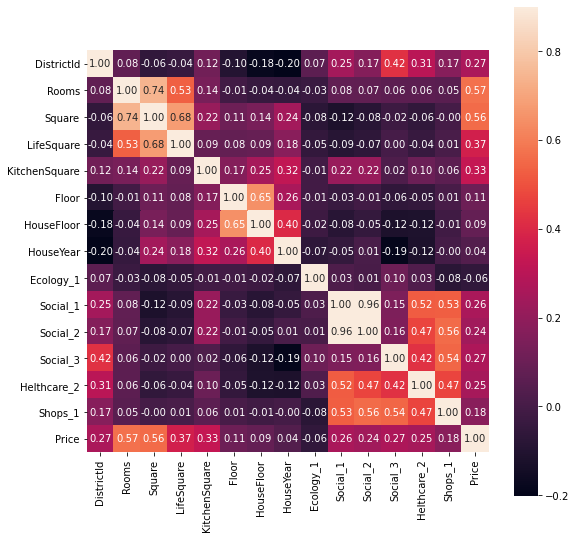

In [105]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(dataset_corr, vmax=0.9, annot=True, square=True, fmt='.2f')
plt.show()

По диаграмме можно заметить следующее:
1. С целевой переменной Price сильно коррелируют признаки Square и Rooms, которые также сильно коррелируют между собой.
2. Переменная LifeSquare средне коррелирует с Price, но также сильно коррелирует с Square.
3. Интересно то, что Square и LifeSquare слабо коррелируют с KitchenSquare. Вполне логично, что кухня не будет всегда становиться больше с увеличением размеров квартиры. В то же время KitchenSquare средне коррелирует с HouseYear - возможно от года к году планировка кухни менялась.
4. Признаки Social_1 и Social_2 показывают очень высокую, почти полную корреляцию - 0.96.
5. Признаков Floor и HouseFloor средне (почти сильно) коррелируют друг с другом.
7. Признаки Helthcare_2 и Shops_1 средне коррелируют между собой, а также с признаками Social_1, Social_2, Social_3.

Между признаками Social_1 и Social_2 почти полная корреляция.\
К сожалению, не известен смысл этих признаков, но они оба являются социальными показателями местности.\
По этим двум причинам можно предположить, что второй признак добавит мало полезной информации к модели.\
Из-за этого признак Social_2 можно убрать из датасета.

In [106]:
train_df = train_df.drop(columns='Social_2')

**Парные диаграммы для наиболее коррелирующих с Price признаками (corr_coef > 0.25)**

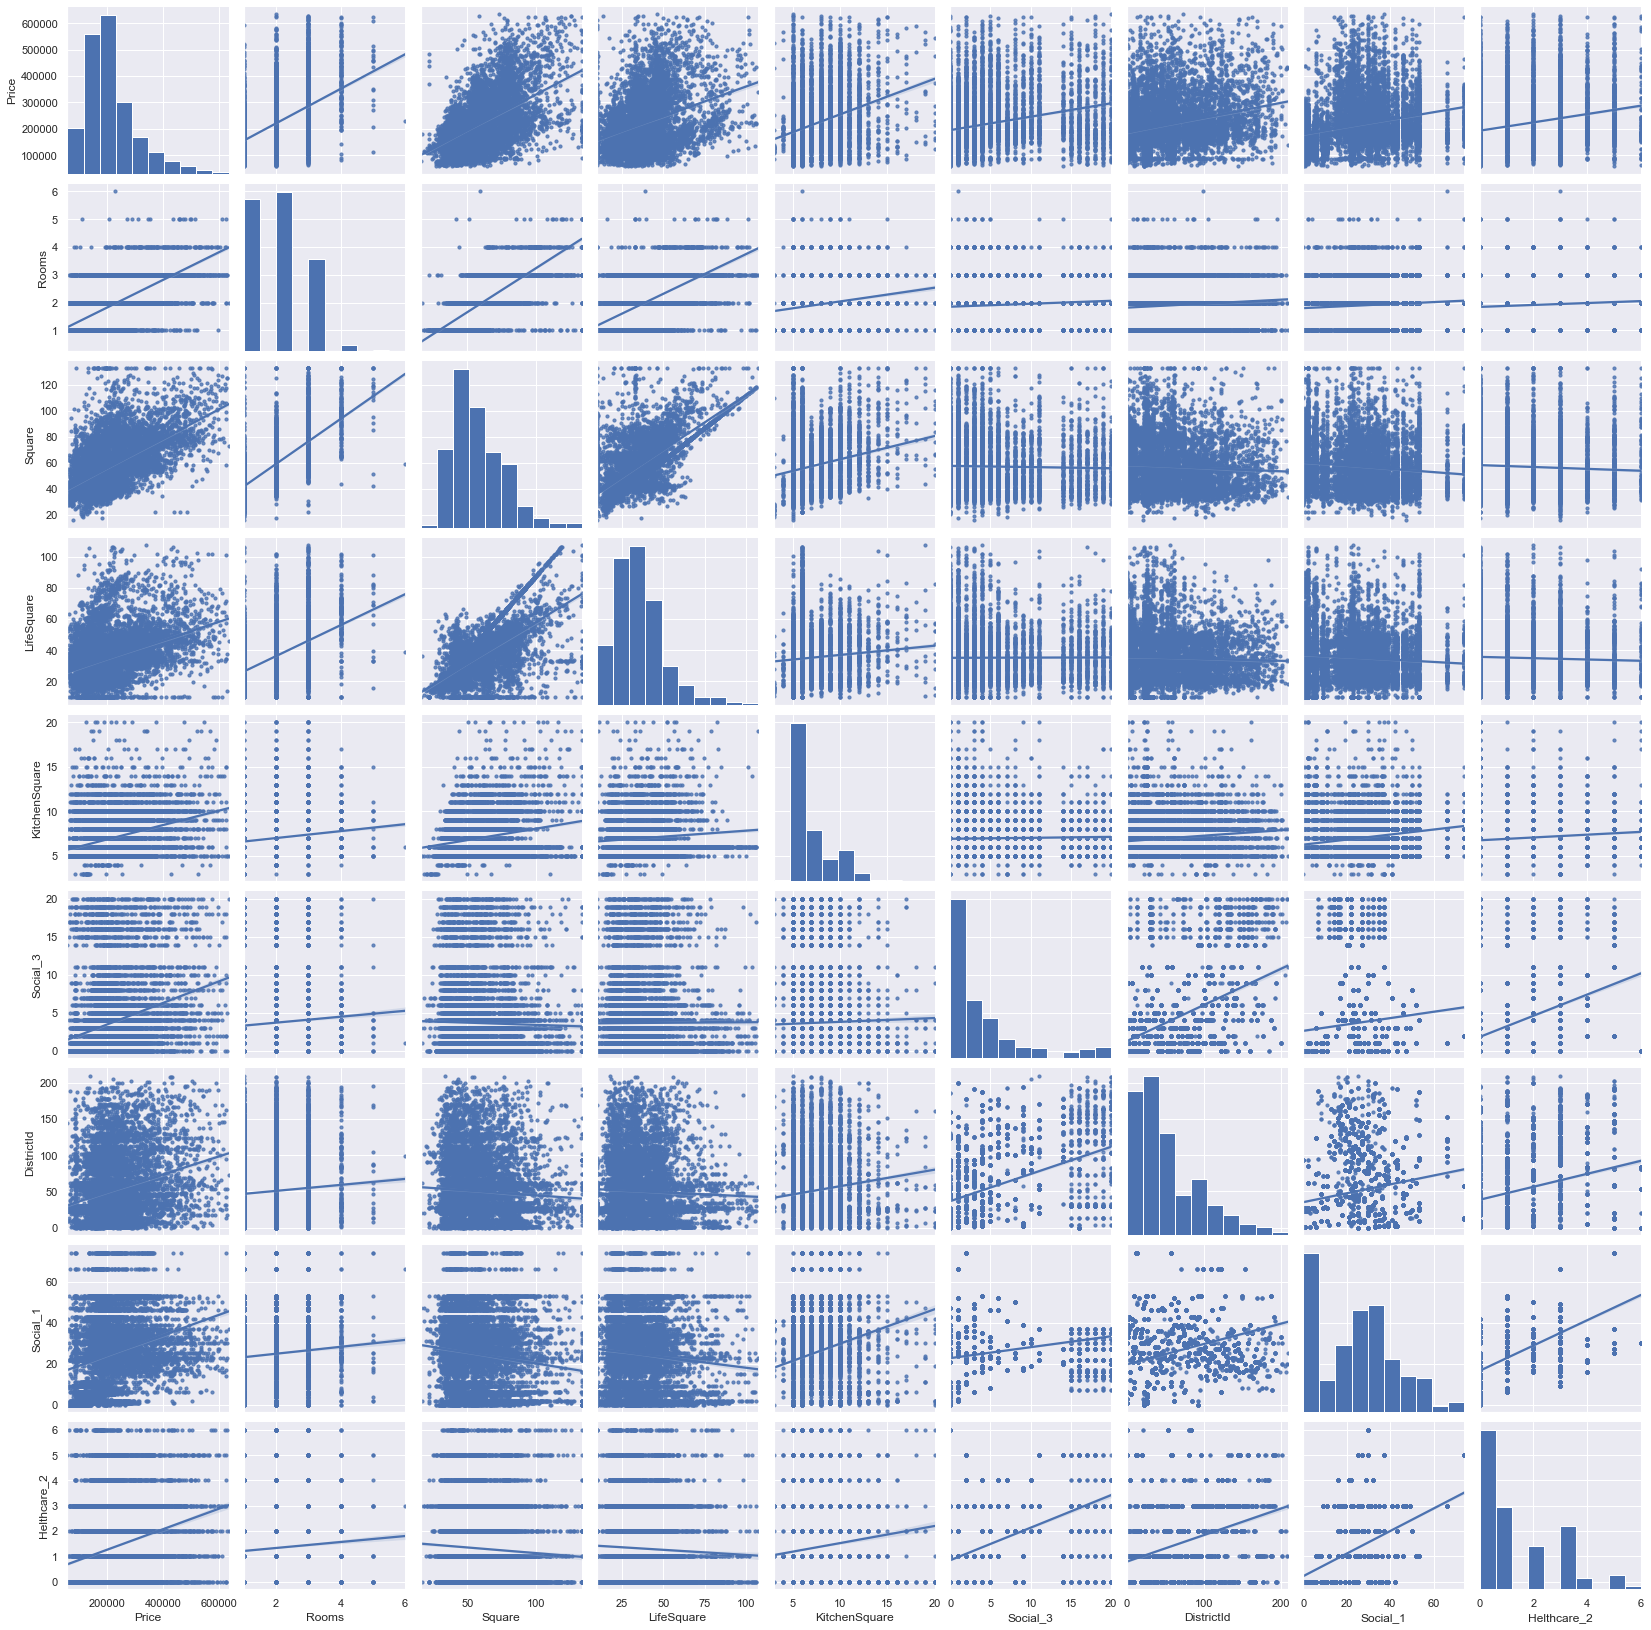

In [107]:
price_corr = dataset_corr.loc[:, 'Price'].sort_values(ascending=False)
price_corr = price_corr[price_corr > 0.25]

sns.set()
sns.pairplot(train_df[price_corr.index],
             height=2.5,
             kind='reg', 
             plot_kws={'scatter_kws': {'s': 10}})

* Для Square и LifeSquare можно заметить четкую наклонную границу - так выглядит условие Square > LifeSquare + KitchenSquare, которое было применено в секции обработки выбросов.

**Зависимости между признаками Rooms и признаком Square, LifeSquare, KitchenSquare, а также таргетом Price**

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

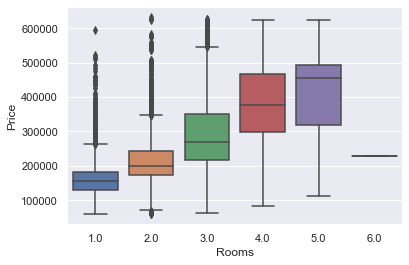

In [108]:
sns.boxplot(y=train_df['Price'], x=train_df['Rooms'].astype('category'))

<AxesSubplot:xlabel='Rooms', ylabel='Square'>

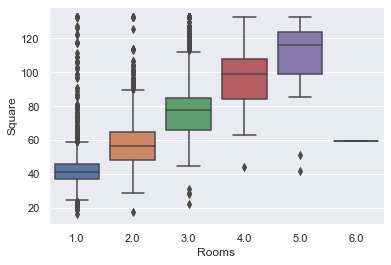

In [109]:
sns.boxplot(y=train_df['Square'], x=train_df['Rooms'].astype('category'))

<AxesSubplot:xlabel='Rooms', ylabel='LifeSquare'>

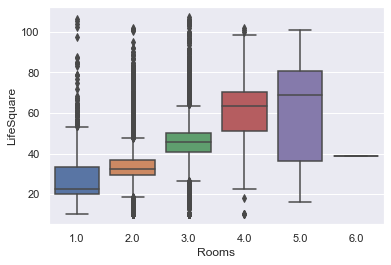

In [110]:
sns.boxplot(y=train_df['LifeSquare'], x=train_df['Rooms'].astype('category'))

<AxesSubplot:xlabel='Rooms', ylabel='KitchenSquare'>

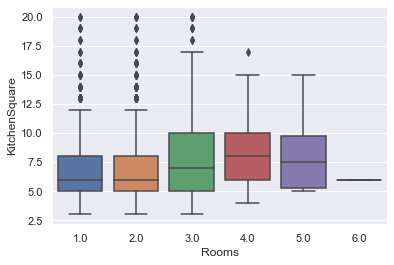

In [111]:
sns.boxplot(y=train_df['KitchenSquare'], x=train_df['Rooms'].astype('category'))

* C увеличением значения признака Rooms медианы Price, Square, LifeSquare стабильно увеличивается, что указывает на степень корреляции этих признаков.
* Медиана признака KitchenSquare только незначительно увеличивается при увеличении признака Rooms.

**Зависимости между признаками Ecology_2, Ecology_3, Shops_2 и целевой переменной Price**

<AxesSubplot:xlabel='Price', ylabel='Shops_2'>

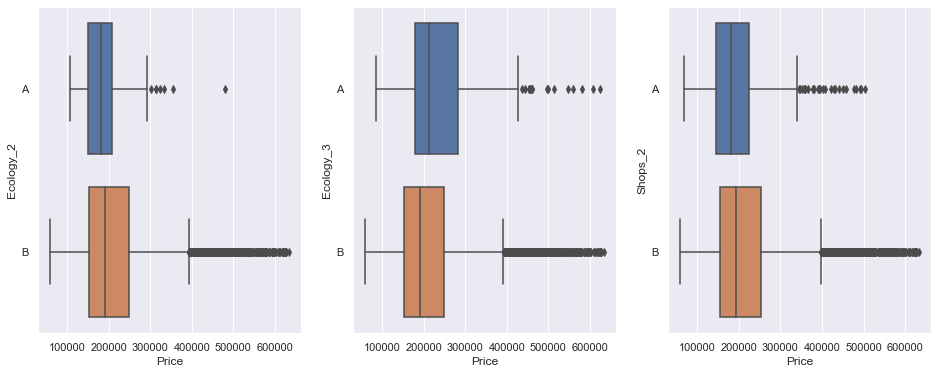

In [112]:
fig, ax = plt.subplots(ncols=3, figsize=(16,6))
ax = ax.flatten()

sns.boxplot(train_df['Price'], train_df['Ecology_2'], ax=ax[0])
sns.boxplot(train_df['Price'], train_df['Ecology_3'], ax=ax[1])
sns.boxplot(train_df['Price'], train_df['Shops_2'], ax=ax[2])

* Ecology_2, Ecology_3, Shops_2 слабо влияют на целевую переменную Price.

**Зависимости между признаком DistrictId и целевой переменной Price**

<AxesSubplot:xlabel='Price', ylabel='DistrictId'>

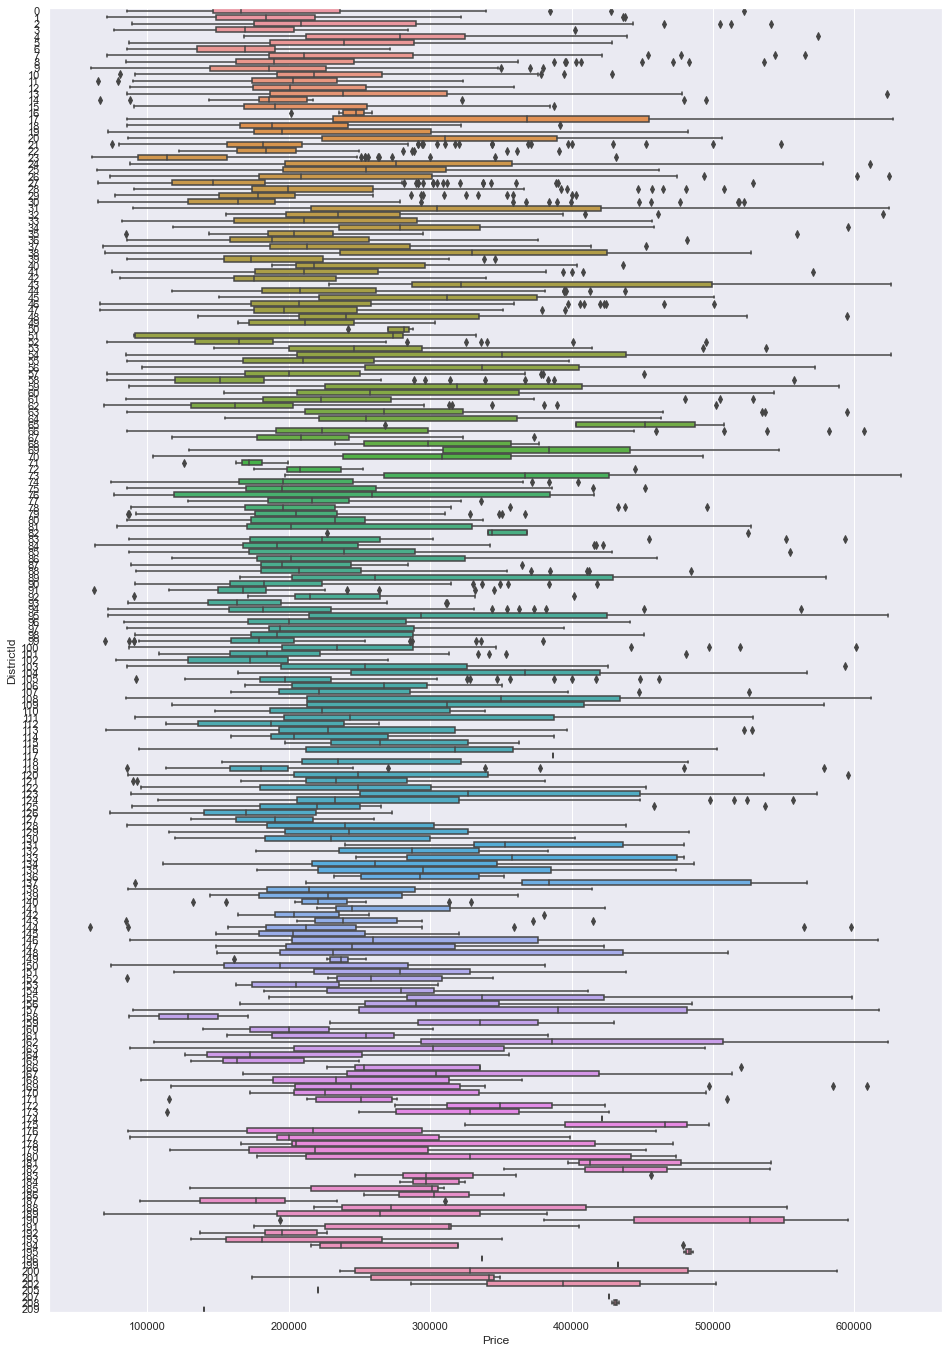

In [113]:
plt.figure(figsize=(16,24))
sns.boxplot(train_df['Price'], train_df['DistrictId'].astype('category'))

* Можно выделить районы с дорогими и дешевыми квартирами, но особых закономерностей на графике не наблюдается, отчасти из-за большого количества различных значений категории DistrictId.

**Зависимости между признаками группы Social**

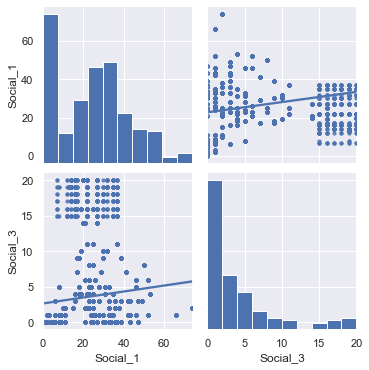

In [114]:
sns.pairplot(train_df[['Social_1', 'Social_3']],
             kind='reg',
             plot_kws={'scatter_kws': {'s': 10}})

* Social_3 слабо связан с Social_1.

**Зависимости между HouseYear, HouseFloor**

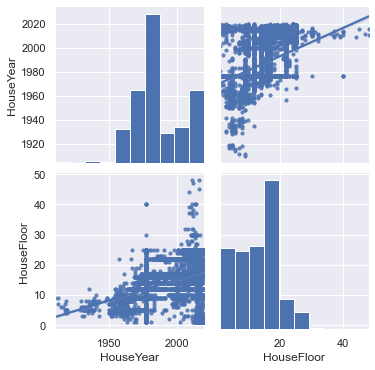

In [115]:
sns.pairplot(train_df[['HouseYear', 'HouseFloor']],
             kind='reg',
             plot_kws={'scatter_kws': {'s': 10}})

* Между данными признаками есть средняя корреляция - чем позднее построены дома, тем выше они могут быть. Пропорция более высоких домов также увеличивается.
* Можно отметить, что есть очень большое количество домов, построенных в 1977 году.

### 1.6. Трансформация переменных

**Замена значений 'A', 'B' категориальных признаков на значения 0, 1.**

In [116]:
cat_to_binary = {'A': 0, 'B': 1}

cat_feature_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
for feature in cat_feature_names:
    train_df[feature] = pd.Series(train_df[feature].map(cat_to_binary), dtype=np.int8)

train_df[cat_feature_names]

,Ecology_2,Ecology_3,Shops_2
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
9995,1,1,1
9996,1,1,0
9997,1,1,0
9998,1,0,1


### 1.7. Генерация новых признаков

### 1.8. Отбор признаков

In [117]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [118]:
features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Ecology_2', 'Ecology_3',
            'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
new_features = []
target_variable = 'Price'

In [119]:
train_df = train_df[features + new_features + [target_variable]]

### 1.9. Стандартизация

In [120]:
features_to_standard = train_df[features].select_dtypes(include=
                                                        ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
                                                       ).columns.tolist()
features_to_standard

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [121]:
scaler = StandardScaler()
standard_features = scaler.fit_transform(train_df[features_to_standard])
standard_features

array([[-0.35334757,  0.13785663, -0.4978002 , ..., -0.8834798 ,
         1.408356  ,  0.29986373],
       [-0.21568684,  1.3687193 ,  0.43703285, ..., -0.2139233 ,
         2.4487004 ,  0.29986373],
       [ 0.05963463,  0.13785663, -0.6580027 , ..., -0.2139233 ,
        -0.25619525,  0.29986373],
       ...,
       [-0.5368953 , -1.0930061 , -0.5000474 , ..., -0.8834798 ,
        -0.8804019 , -3.3348482 ],
       [ 0.56439066,  0.13785663, -0.72905165, ...,  0.45563316,
         0.15994257,  0.29986373],
       [ 1.7803938 , -1.0930061 , -0.9897136 , ...,  0.45563316,
         0.7841492 ,  0.29986373]], dtype=float32)

In [122]:
train_df[features_to_standard] = pd.DataFrame(standard_features, columns=features_to_standard)

### 1.10. Трансформация признака Rooms в категориальный

В признаке Rooms остается только 6 значений - от 1 до 6 комнат.\
Сделаем этот признак категориальным.

In [123]:
train_df['Rooms'] = train_df['Rooms'].astype('category')

In [124]:
train_df = pd.get_dummies(train_df, drop_first=True)

### 1.11. Описание обработанных данных

In [125]:
train_df.describe()

,DistrictId,Square,LifeSquare,KitchenSquare,Ecology_2,Ecology_3,Social_1,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_0.1378566324710846,Rooms_1.3687193393707275,Rooms_2.5995819568634033,Rooms_3.830444574356079,Rooms_5.061307430267334
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0000
mean,-2.861023e-10,-1.525879e-09,-1.163483e-08,1.907349e-10,-3.242493e-08,-3.051758e-08,-1.220703e-08,3.673900,5.722046e-09,5.340576e-09,1.602173e-08,214138.859375,0.388300,0.223500,0.015000,0.00180,0.0001
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,4.915565,1.000050e+00,1.000050e+00,1.000050e+00,92872.289062,0.487388,0.416611,0.121559,0.04239,0.0100
min,-1.156368e+00,-2.180535e+00,-1.664114e+00,-1.747775e+00,-1.010410e+01,-5.946733e+00,-1.408132e+00,0.000000,-8.834798e-01,-8.804019e-01,-3.334848e+00,59174.777344,0.000000,0.000000,0.000000,0.00000,0.0000
25%,-6.974995e-01,-7.897915e-01,-7.882329e-01,-8.683694e-01,9.896975e-02,1.681595e-01,-1.065895e+00,0.000000,-8.834798e-01,-6.723331e-01,2.998637e-01,153872.628906,0.000000,0.000000,0.000000,0.00000,0.0000
50%,-3.304041e-01,-1.782298e-01,-1.584013e-01,-4.286664e-01,9.896975e-02,1.681595e-01,1.785333e-02,2.000000,-2.139233e-01,-2.561952e-01,2.998637e-01,192269.648438,0.000000,0.000000,0.000000,0.00000,0.0000
75%,5.643907e-01,5.299827e-01,5.636016e-01,4.507395e-01,9.896975e-02,1.681595e-01,6.452869e-01,5.000000,4.556332e-01,3.680115e-01,2.998637e-01,249135.460938,1.000000,0.000000,0.000000,0.00000,0.0000
max,3.638814e+00,3.982500e+00,4.771899e+00,5.727175e+00,9.896975e-02,1.681595e-01,2.812784e+00,20.000000,3.133859e+00,3.905183e+00,2.998637e-01,633233.437500,1.000000,1.000000,1.000000,1.00000,1.0000


# 2. Классы генерации признаков и предобработки данных

In [126]:
class FeatureGenerator():
    """Class for generating new features for the dataset."""
    def __init__(self):
        self.CURRENT_YEAR = datetime.datetime.now().year
        self.BOOL_TO_INT = {False: 0, True: 1}
        
        self.district_counts = None
        self.med_square_per_district = None
        self.avg_rooms_per_district = None
        self.med_house_age_per_district = None
        self.med_house_floor_per_district = None
    
    def fit(self, X, y=None):
        X = X.copy()
        
        # DistrictTotalFlats
        self.district_counts = dict(X['DistrictId'].value_counts())
        # DistrictMedianSquare
        self.med_square_per_district = X.groupby('DistrictId')['Square'].median()
        # DistrictAvgRooms
        self.avg_rooms_per_district = X.groupby('DistrictId')['Rooms'].sum() / X['DistrictId'].value_counts()
        # DistrictMedianHouseAge
        X['HouseAge'] = self.CURRENT_YEAR - X['HouseYear']
        self.med_house_age_per_district = X.groupby('DistrictId')['HouseAge'].median()
        # DistrictMedianHouseFloor
        self.med_house_floor_per_district = X.groupby('DistrictId')['HouseFloor'].median()
    
    def transform(self, X):
        # DistrictTotalFlats
        X['DistrictTotalFlats'] = X['DistrictId'].map(self.district_counts)
        # DistrictMedianSquare
        X['DistrictMedianSquare'] = X['DistrictId'].map(self.med_square_per_district)
        # DistrictAvgRooms
        X['DistrictAvgRooms'] = X['DistrictId'].map(self.avg_rooms_per_district)
        # HouseAge
        X['HouseAge'] = self.CURRENT_YEAR - X['HouseYear']
        # DistrictMedianHouseAge
        X['DistrictMedianHouseAge'] = X['DistrictId'].map(self.med_house_age_per_district)
        # DistrictMedianHouseFloor
        X['DistrictMedianHouseFloor'] = X['DistrictId'].map(self.med_house_floor_per_district)
        # LifeSquarePerRoom
        X['LifeSquarePerRoom'] = X['LifeSquare'] / X['Rooms']
        # IsHighSocial
        X['IsHighSocial'] = (X['Social_3'] >= 15).map(self.BOOL_TO_INT)
        # HouseIsOld
        X['HouseIsOld'] = (X['HouseAge'] >= 30).map(self.BOOL_TO_INT)
        
        return X

In [127]:
class DataPipeline():
    """Class for cleaning and transforming data, generating new features in the dataset."""
    def __init__(self, scaler_path='./scaler.pkl'):
        """..."""
        self.ADDITIONAL_NONLIFE_SQUARE = 6
        self.CUTOFF_SOCIAL_3 = 20
        self.CAT_TO_BINARY = {'A': 0, 'B': 1}
        self.CAT_FEATURE_NAMES = ['Ecology_2', 'Ecology_3', 'Shops_2']
        self.NUM_FEATURE_TYPES = ['int8', 'int16', 'int32', 'int64', 'float32', 'float64']
        self.FEATURES = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Ecology_2', 'Ecology_3',
                         'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']
        # Not used because new features made Kaggle R2 score worse.
#         self.NEW_FEATURES = ['DistrictTotalFlats', 'DistrictMedianSquare', 'DistrictAvgRooms', 'HouseAge', 
#                              'DistrictMedianHouseAge', 'DistrictMedianHouseFloor', 'LifeSquarePerRoom', 'IsHighSocial', 
#                              'HouseIsOld']
        self.NEW_FEATURES = []
        self.TARGET_VARIABLE = 'Price'
        self.SCALER_FILEPATH = scaler_path
        
        self.medians = None
        self.house_floor_1977_median = None
        self.lifesquare_robust_std = None
        self.square_quantile = None
        self.lifesquare_quantile = None
        self.kitchsquare_quantile = None
        
        self.scaler = None
        self.feature_gen = None
    
    def fit(self, X, y=None):
        """Fitting the pipeline - getting dataset statistics and fitting the scaler model."""
        self.medians = X.median()
        self.house_floor_1977_median = X.loc[X['HouseYear'] == 1977, 'HouseFloor'].median()
        self.lifesquare_robust_std = (X['LifeSquare'].quantile(q=0.75) - X['LifeSquare'].quantile(q=0.25)) / 2
        self.square_quantile = X['Square'].quantile(q=0.995)
        self.lifesquare_quantile = X['LifeSquare'].quantile(q=0.995)
        self.kitchsquare_quantile_75 = X['KitchenSquare'].quantile(q=0.75)
        self.kitchsquare_quantile_995 = X['KitchenSquare'].quantile(q=0.995)
        
        self.scaler = StandardScaler()
        
    def transform(self, X):
        """Cleaning, transforming data, generating new features."""
        X = self.drop_features(X)
        X = DataPipeline.reduce_mem_usage(X)
        
        X = self.process_outliers_and_nans(X)
        X = self.convert_cat_to_int(X)
        
        # Generating new features
        self.feature_gen = FeatureGenerator()
        if self.TARGET_VARIABLE in X.columns:
            self.feature_gen.fit(X.drop(columns=self.TARGET_VARIABLE), X[self.TARGET_VARIABLE])
        else:
            self.feature_gen.fit(X)
        # Not used because new features made Kaggle R2 score worse.
        # X = self.feature_gen.transform(X)

        # Make Rooms into a category feature
        X['Rooms'] = X['Rooms'].astype('category')
        
        # Choosing features
        if self.TARGET_VARIABLE in X.columns:
            X = X[self.FEATURES + self.NEW_FEATURES + [self.TARGET_VARIABLE]]
        else:
            X = X[self.FEATURES + self.NEW_FEATURES]
        
        X = self.standardize_features(X)
        
        return X
    
    @staticmethod
    def reduce_mem_usage(df):
        """ Iterate through all the columns of a dataframe and modify the data type
            to reduce memory usage.
            From Kaggle Notebook:
            https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
        """
        for col in df.columns:
            col_type = df[col].dtype

            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    # Breaks statistics because of the Pandas issue
                    # if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    #     df[col] = df[col].astype(np.float16)
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        return df
    
    def drop_features(self, X):
        """Dropping useless features in the dataset."""
        if 'Id' in X.columns:
            X = X.drop(columns=['Id'])
        if 'Healthcare_1' in X.columns:
            X = X.drop(columns=['Healthcare_1'])
        if 'Social_2' in X.columns:
            X = X.drop(columns=['Social_2'])
        
        return X
    
    def process_outliers_and_nans(self, X):
        """Processing outliers and missing values in the dataset."""
        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        # Square
        X.loc[X['Square'] < 10, 'Square'] = 10
        X.loc[X['Square'] > self.square_quantile, 'Square'] = self.square_quantile
        # LifeSquare
        X.loc[X['LifeSquare'] > self.lifesquare_quantile, 'LifeSquare'] = self.medians['LifeSquare']
        new_lifesquare = np.random.normal(self.medians['LifeSquare'], self.lifesquare_robust_std, X['LifeSquare'].isna().sum())
        new_lifesquare = pd.Series(new_lifesquare, index=X[X['LifeSquare'].isna()].index)
        X['LifeSquare'] = X['LifeSquare'].fillna(new_lifesquare)
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = 10
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = np.random.randint(3, self.kitchsquare_quantile_75)
        X.loc[X['KitchenSquare'] > self.kitchsquare_quantile_995, 'KitchenSquare'] = self.medians['KitchenSquare']
        # Square > LifeSquare + KitchenSquare + additional_nonlife_square
        X.loc[X['Square'] < X['LifeSquare'] + X['KitchenSquare'], 
                       'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['Square'] < X['LifeSquare'] + X['KitchenSquare'], 
                       'Square'] = X['LifeSquare'] + X['KitchenSquare'] + self.ADDITIONAL_NONLIFE_SQUARE
        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = self.medians['HouseYear']
        # HouseFloor
        X.loc[X['HouseFloor'] > 95, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.house_floor_1977_median
        # Floor
        floor_error_index = X[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_error_index, 'Floor'] = X.loc[floor_error_index, 'HouseFloor'].map(lambda x: np.random.randint(1, x + 1))
        # Social_3
        X.loc[X['Social_3'] > self.CUTOFF_SOCIAL_3, 
                     'Social_3'] = np.random.randint(self.CUTOFF_SOCIAL_3 - 5, 
                                                     self.CUTOFF_SOCIAL_3 + 1, 
                                                     X.loc[X['Social_3'] > self.CUTOFF_SOCIAL_3].shape[0])
        
        return X
    
    def convert_cat_to_int(self, X):
        """Convert category columns to binary int columns."""
        for feature in self.CAT_FEATURE_NAMES:
            X[feature] = pd.Series(X[feature].map(self.CAT_TO_BINARY), dtype=np.int8)
        
        return X

    def standardize_features(self, X):
        features_to_standard = X[self.FEATURES].select_dtypes(include=self.NUM_FEATURE_TYPES).columns.tolist()
        
        self.scaler.fit(X[features_to_standard])
        standard_features = self.scaler.transform(X[features_to_standard])
        X[features_to_standard] = pd.DataFrame(standard_features, columns=features_to_standard)
        
        with open(self.SCALER_FILEPATH, 'wb') as file:
            pickle.dump(scaler, file)
        
        return X

**Обработка датасетов классом DataPipeline**

Загрузим изначальные датасеты train, test и обработаем их с помощью класса DataPipeline.

In [128]:
train_df = pd.read_csv(TRAIN_FILEPATH)
test_df = pd.read_csv(TEST_FILEPATH)
train_df.shape, test_df.shape

((10000, 20), (5000, 19))

In [129]:
pipeline = DataPipeline()
pipeline.fit(train_df)

train_df = pipeline.transform(train_df)
test_df = pipeline.transform(test_df)
train_df.shape, test_df.shape

((10000, 13), (5000, 12))

In [130]:
train_df = pd.get_dummies(train_df, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

In [131]:
train_df.columns, test_df.columns

(Index(['DistrictId', 'Square', 'LifeSquare', 'KitchenSquare', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1',
        'Shops_2', 'Price', 'Rooms_2.0', 'Rooms_3.0', 'Rooms_4.0', 'Rooms_5.0',
        'Rooms_6.0'],
       dtype='object'),
 Index(['DistrictId', 'Square', 'LifeSquare', 'KitchenSquare', 'Ecology_2',
        'Ecology_3', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1',
        'Shops_2', 'Rooms_2.0', 'Rooms_3.0', 'Rooms_4.0', 'Rooms_5.0',
        'Rooms_6.0'],
       dtype='object'))

# 3. Сохранение обработанного датасета

In [132]:
train_df.to_csv(PREPARED_TRAIN_FILEPATH, sep=',', index=False, encoding='utf-8')

# 4. Разбиение на train, test

In [133]:
X = train_df.drop('Price', axis=1)
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# 5. Построение модели

### Обучение модели

**Gradient Boost**

Модель GradientBoostingRegressor и ее гиперпараметры были выбраны, так как показатель R2 для кросс-валидации для такой модели был лучше, чем у других моделей.

In [134]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                 n_estimators=100,
                                 max_depth=7,
                                 min_samples_leaf=10,
                                 random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

# 6. Настройка и валидация конечной модели

### Оценка модели

**Gradient Boost**

Train R2:	0.852
Train RMSE:	35664.014
Train MSE:	1271921860.01

Test R2:	0.697
Test RMSE:	51585.073
Test MSE:	2661019799.184


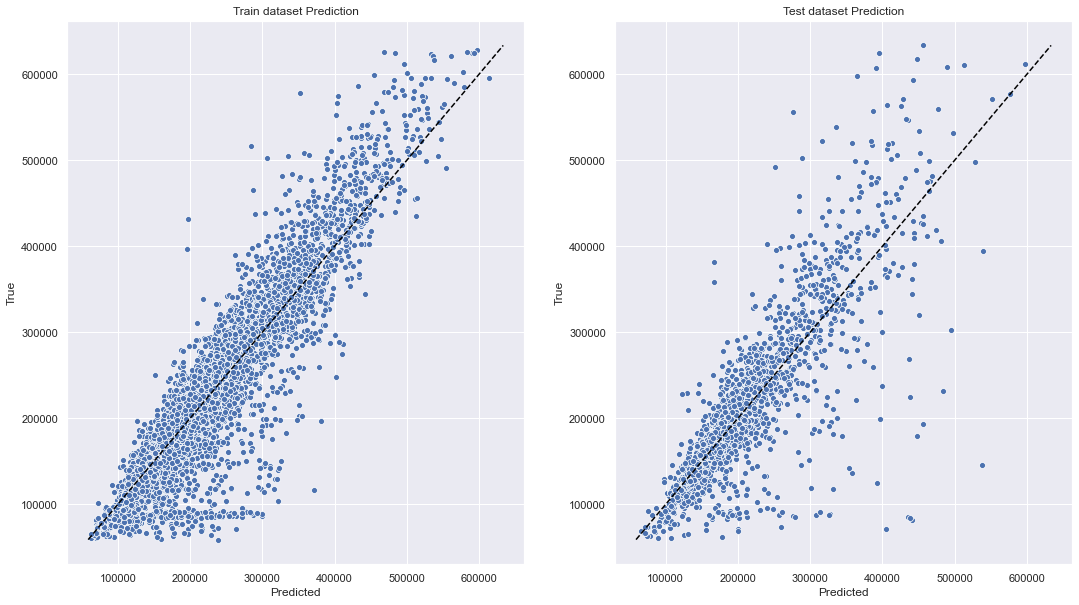

In [135]:
y_train_preds_gb = gb_model.predict(X_train)
y_test_preds_gb = gb_model.predict(X_test)

eval_predictions(y_train, y_train_preds_gb, y_test, y_test_preds_gb)

### Кросс-валидация

**Gradient Boost**

In [136]:
cv_score_gb = cross_val_score(gb_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score_gb

array([0.69673193, 0.70936144, 0.70749147, 0.70376177, 0.74392718])

In [137]:
cv_score_gb.mean()

0.7122547563279797

# 7. Анализ прогнозов модели

### Важность признаков

**Gradient Boosting**

In [138]:
feature_importance_gb = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importance_gb = feature_importance_gb.sort_values(by='importance', ascending=False)
feature_importance_gb

,feature_name,importance
1,Square,0.436082
6,Social_1,0.250476
0,DistrictId,0.086229
7,Social_3,0.061608
9,Shops_1,0.044795
2,LifeSquare,0.042987
3,KitchenSquare,0.035796
11,Rooms_2.0,0.018239
8,Helthcare_2,0.015634
12,Rooms_3.0,0.004929


### Топ-3 фичи

**Gradient Boosting**

In [139]:
feature_importance_gb.head(3)

,feature_name,importance
1,Square,0.436082
6,Social_1,0.250476
0,DistrictId,0.086229


### Худшие 3 фичи

**Gradient Boosting**

In [140]:
feature_importance_gb.tail(3)

,feature_name,importance
5,Ecology_3,0.000200
14,Rooms_5.0,0.000106
15,Rooms_6.0,0.000000


# 8. Сохранение модели

In [141]:
with open(MODEL_FILEPATH, 'wb') as file:
    pickle.dump(gb_model, file)

In [142]:
with open(MODEL_FILEPATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

Запишем версию sklearn, в которой была сделана модель, в файл sklearn_version.txt.

In [143]:
import sklearn
print(sklearn.__version__)
with open('./sklearn_version.txt', 'w', encoding='utf-8') as file:
    file.write(f"Scikit-learn version: {sklearn.__version__}")

0.23.2


# 9. Прогнозирование на тестовом датасете

Загружаем пример сдачи результатов на Kaggle.

In [144]:
submit = pd.read_csv('./dataset/sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


Предсказываем результаты на test.csv.\
Так как к целевой переменной Price был применен log-transform, нужно обратить эту операцию с помощью numpy.exp().

In [145]:
predictions = gb_model.predict(test_df)
predictions

array([160604.81269554, 227926.11710764, 193251.82106159, ...,
       312818.40680422, 183185.21730317, 173150.9587363 ])

Сохраняем предсказания модели в файл на основе примера сдачи. 

In [146]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,160604.812696
1,15856,227926.117108
2,5480,193251.821062
3,15664,317870.243410
4,14275,137651.823586


In [147]:
submit.to_csv('submission.csv', index=False)